In [ ]:
 %pip install --upgrade keras

In [ ]:
 %pip install torch torchvision torchaudio

In [ ]:
%pip install scikit-learn pandas matplotlib transformers -U

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.2.0


In [ ]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
data.topic.value_counts()

topic
Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: count, dtype: int64

In [ ]:
data.shape

(607, 6)

In [ ]:
# №1 Замороженная предобученная модель

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("distilbert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
# Заморозка весов
for param in model_bert.parameters():
    param.requires_grad = False

In [ ]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")


output = bert_wrapper(model_bert)(input_word_ids)
# добавим дропаут чтобы не переобучалось
drop = keras.layers.Dropout(0.1)(output[:, 0]) # [0][:, 0] - означает что мы берем первое
                                                     # состояние у всех текстов в батче
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

# обычно при дообучении трансформеров нужно ставить очень маленький лосс
# но когда мы обучаем только итоговый классификатор то можно ставить побольше
model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_wrapper (bert_wrapper)          │ (None, 512, 768)            │     134,734,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │          13,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,747,153 (514.02 MB)

 Trainable params: 13,073 (51.07 KB)

 Non-trainable params: 134,734,080 (513.97 MB)

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [ ]:
model_clf.fit(torch.LongTensor(X_train),
              torch.LongTensor(y_train),
              validation_data=(torch.LongTensor(X_valid),
                               torch.LongTensor(y_valid)),
                               batch_size=20, epochs=20)

Epoch 1/20


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


29/29 ━━━━━━━━━━━━━━━━━━━━ 805s 28s/step - accuracy: 0.0415 - loss: 2.8510 - rec_prec: 4.5707e-04 - val_accuracy: 0.1290 - val_loss: 2.7289 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 676s 23s/step - accuracy: 0.0795 - loss: 2.7699 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.6961 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 674s 23s/step - accuracy: 0.1098 - loss: 2.7264 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.7013 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 660s 23s/step - accuracy: 0.1202 - loss: 2.7192 - rec_prec: 5.1587e-04 - val_accuracy: 0.0968 - val_loss: 2.7009 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 652s 22s/step - accuracy: 0.1001 - loss: 2.6777 - rec_prec: 8.8951e-04 - val_accuracy: 0.0968 - val_loss: 2.6894 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 654s 23s/step - accuracy: 0.1262 - loss: 2.7305 - rec_prec: 3.1818e-04 - val_accura

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


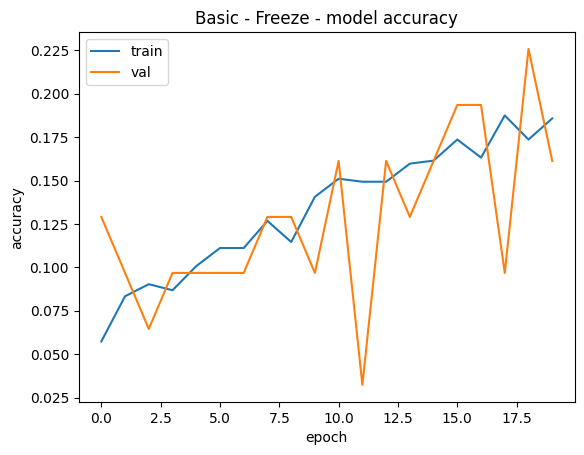

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('Basic - Freeze - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step
                   precision    recall  f1-score   support

           Россия       0.00      0.00      0.00         2
              Дом       0.00      0.00      0.00         2
         Из жизни       0.00      0.00      0.00         3
   69-я параллель       0.00      0.00      0.00         1
              Мир       0.00      0.00      0.00         1
  Наука и техника       0.00      0.00      0.00         3
         Ценности       0.00      0.00      0.00         2
Силовые структуры       0.50      1.00      0.67         2
   Интернет и СМИ       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
      Бывший СССР       0.20      0.33      0.25         3
       Библиотека       0.00      0.00      0.00         0
         Культура       0.18      0.67      0.29         3
            Спорт       0.00      0.00      0.00         2
           Бизнес 